### Förbereda datan

Jag gör en snabb kontroll av vilken Python environment/kernel som jag kör i eftersom VS Code ibland har valt fel interpreter.

Sedan importerar jag relevanta bibliotek (t.ex. Numpy och fetch_openml från scikit-learn/sklearn), laddar MNIST och plockar ut X (data/features) och y (target/labels).

In [3]:
import sys
print(sys.executable)
print(sys.version)

/Users/jonaswepsalainen/Python/.venv/bin/python
3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]


In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import certifi
import os
import ssl
from urllib.error import URLError
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score 

Jag förbereder för att kunna hämta MNIST via OpenML över HTTPS

På min Mac så krävdes det ett certifikat innnan jag kan hämta mnist och det installerar jag nedan

In [5]:
import ssl
try:
    mnist = fetch_openml("mnist_784", version = 1, cache = True, as_frame = False)
except URLError:
    os.environ['SSL_CERT_FILE'] = '/Users/jonaswepsalainen/Python/.venv/lib/python3.13/site-packages/certifi/cacert.pem'
    print(os.environ['SSL_CERT_FILE'])
    mnist = fetch_openml("mnist_784", version = 1, cache = True, as_frame = False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Jag gör lite olika kontroller av datan och med vad den är för något. Jag gör det i småsteg då jag inte tycker att jag kan det tillräckligt och jag behöver öva mer.

In [6]:
print(mnist.data)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
print(mnist.target)

['5' '0' '4' ... '4' '5' '6']


Assignar X och y värden samt gör en utskrift på dem och kontrollerar vilka typer det är.

In [8]:
X = mnist.data
y = mnist.target

print(X.shape)
print(y.shape)

print(len(y[:10]))
print(y[:10])

(70000, 784)
(70000,)
10
['5' '0' '4' '1' '9' '2' '1' '3' '1' '4']


In [9]:
type(X)


numpy.ndarray

In [10]:
type(y)

numpy.ndarray

Jag konverterar y till int och en lista

In [11]:
y = y.astype(np.int8)
print(y[:10])
y.dtype

[5 0 4 1 9 2 1 3 1 4]


dtype('int8')

Jag delar upp datan i train (80%) och test (20%) för en slutlig, oberoende utvärdering. Under modellutveckling använder jag K-fold cross-validation på träningsdatan, därför behövs ingen separat valideringssplit.

Jag undviker även data leakage genom att all preprocessing (t.ex. scaling) görs inne i varje CV-fold (t.ex. med Pipeline).


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56000, 784)
(14000, 784)
(56000,)
(14000,)


### EDA

In [13]:
X_eda = X_train.copy()
y_eda = y_train.copy()

Kontroll med shape så att de har sammas storlek som originalen

In [14]:
print(X_train.shape)
print(X_eda.shape)
print(y_train.shape)
print(y_eda.shape)

(56000, 784)
(56000, 784)
(56000,)
(56000,)


Samt att de ligger på olika minnesadresser

In [15]:
print(id(X_train))
print(id(X_eda))
print(id(y_train))
print(id(y_eda))

4736593008
4736593680
4736592528
4736593776


In [16]:
X_eda.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
X_train.count()

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [17]:
print(y_eda[0:15])


[5 4 8 0 2 6 5 4 8 3 1 5 9 4 5]


(28, 28)


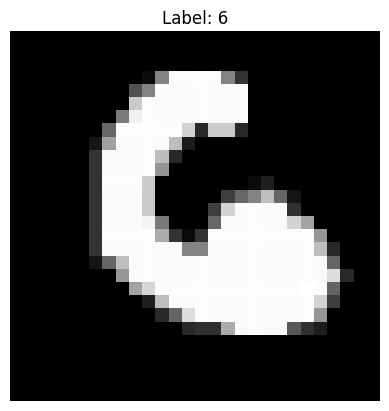

6


In [18]:
i = 5999

row = X_eda[i]                # Sätter pixelraden i row
row.shape                     # .shape visar antalet dimensioner i row

img = row.reshape(28, 28)     # Gör om row till 28*28 bild (28 rader med 28 pixlar)
print(img.shape)              # Kontroll av bildens shape (ska vara (28, 28))

plt.imshow(img, cmap = "gray")
plt.axis("off")
label = y_eda[i]
plt.title(f"Label: {label}")
plt.show()

print(y_eda[i])

Provar att göra om det till en loop för att kontrollera att fler tal är korrekt

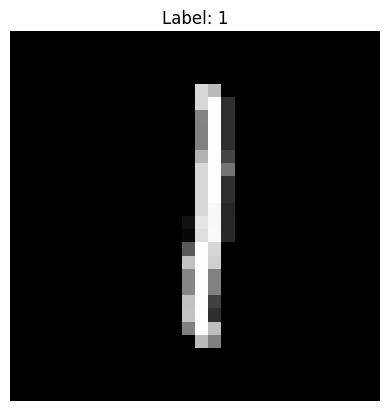

Index: 10, Label: 1, row shape: (784,)


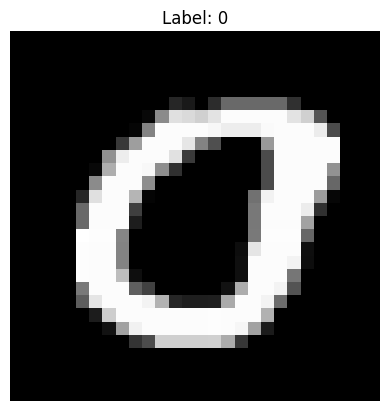

Index: 100, Label: 0, row shape: (784,)


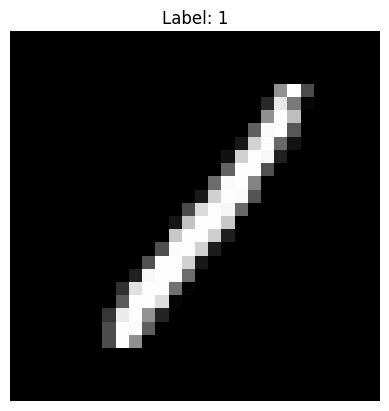

Index: 1000, Label: 1, row shape: (784,)


In [19]:
kontroll_lista = [10, 100, 1000]

for i in kontroll_lista:
    row = X_eda[i]                # Sätter pixelraden i row

    img = row.reshape(28, 28)     # Gör om row till 28*28 bild (28 rader med 28 pixlar)

    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    label = y_eda[i]
    plt.title(f"Label: {label}")
    plt.show()

    print(f"Index: {i}, Label: {label}, row shape: {row.shape}")

In [20]:
print(X_eda.max())
print(X_eda.min())

255
0


Gör en normalisering av datan

In [21]:
X_eda_scaled = X_eda/X_eda.max() 

print(X_eda_scaled.max(),X_eda.dtype)
print(X_eda_scaled.min(),X_eda_scaled.dtype)


1.0 int64
0.0 float64


Och en normalisering av test datan

In [22]:
scale = X_train.max()
X_train_scaled = X_train/scale 

print(X_train_scaled.max(),X_train.dtype)
print(X_train_scaled.min(),X_train_scaled.dtype)

X_test_scaled = X_test/scale

print(X_test_scaled.max(),X_test.dtype)
print(X_test_scaled.min(),X_test_scaled.dtype)

1.0 int64
0.0 float64
1.0 int64
0.0 float64


## Nu börjar jag med modell-delen 

Börjar med kNeighborsClassifier

In [23]:
kNN_model = KNeighborsClassifier(n_neighbors=3)
print(kNN_model)

kNN_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",3
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


Prediktering... separat för att göra det enklare för mig att felsöka.

“Tänk att varje siffra är en punkt. När modellen ska gissa en ny bild letar den upp de k mest lika bilderna i träningsdatan och låter dem rösta. Flest röster = modellens gissning.”
Tango-liknelse:
“Jag ser ett steg och jämför med mina 3 mest liknande exempel från lektionerna. Om 2 av 3 liknar en ‘ocho’ så gissar modellen ‘ocho’.”

In [26]:
y_pred = kNN_model.predict(X_test_scaled)

y_pred.shape

(14000,)

“Hur många rätt av alla testbilder.” (97.13% betyder ~97 av 100 rätt.)

In [27]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9712857142857143


In [29]:
print(y_pred.shape)
print(acc)

(14000,)
0.9712857142857143


Modell SVC, 

Göre gridserach, kolla på hyperparametrar, itirera och testa olika hyperparsametrar

preprocessa datan så att den fungerar bättre på ens egna siffror

Kolla på Klustring till på torsdag

TEst att github fungerar